# English(LJSpeech-1.1)

- This is a tutorial to make `Forced Aligned Textfile` using [Wav2vec 2.0](https://arxiv.org/abs/2006.11477) released from [fairseq](https://github.com/pytorch/fairseq/blob/main/examples/wav2vec/README.md).
- The original script to use wav2vec 2.0 as a forced aligner can be found in this [link](https://pytorch.org/tutorials/intermediate/forced_alignment_with_torchaudio_tutorial.html)

In [54]:
import os
from dataclasses import dataclass
import torch
import torchaudio
import requests
import matplotlib
import matplotlib.pyplot as plt
import IPython
import pandas as pd
import tgt
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
from pathlib import Path

In [55]:
## set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## load model
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")
model.to(device)

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureExtractor(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        )
        (2): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        )
        (3): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        )
        (4): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        )
        (5): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        )
        (6): Wav2Vec

In [56]:
## get dict
dictionary = processor.tokenizer.get_vocab()
labels = [item for item, idx in dictionary.items()]

## get sampling_rate
w2v_sample_rate = processor.feature_extractor.sampling_rate

In [57]:
## set meta and audio data path of LJSpeech-1.1
data_path = '/code/gitRepo/data/LJSpeech-1.1/wavs'
script_path = '/code/gitRepo/data/LJSpeech-1.1/metadata.csv'

In [58]:
with open(script_path, 'r') as f:
    scripts = f.readlines()

In [59]:
script_index = 1
scripts[script_index].strip().split('|')

['LJ001-0002',
 'in being comparatively modern.',
 'in being comparatively modern.']

In [60]:
item = scripts[script_index].strip().split('|')
audio_path = os.path.join(data_path, item[0])
if Path(audio_path).suffix == '':
    audio_path = '{}.wav'.format(audio_path)
transcript = item[2]
print('[audio_path]', audio_path)
print('[transcript]', transcript)

[audio_path] /code/gitRepo/data/LJSpeech-1.1/wavs/LJ001-0002.wav
[transcript] in being comparatively modern.


In [61]:
## get probs from wav2vec2
with torch.inference_mode():
    waveform, sample_rate = torchaudio.load(audio_path)

    ## only use mono
    if waveform.size(0) > 1:
        waveform = waveform[0, :].view(1, -1)

    if sample_rate != w2v_sample_rate:
        waveform = torchaudio.transforms.Resample(sample_rate, w2v_sample_rate)(waveform)
        sample_rate = w2v_sample_rate

    emissions = model(waveform.to(device))
    emissions = torch.log_softmax(emissions.logits, dim=-1)

emission = emissions[0].cpu().detach()

In [62]:
@dataclass
class Segment:
    label: str
    start: int
    end: int
    score: float

    def __repr__(self):
        return f"{self.label}\t({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

    @property
    def length(self):
        return self.end - self.start
    
@dataclass
class Point:
    token_index: int
    time_index: int
    score: float


def get_trellis(emission, tokens, blank_id=0):
    num_frame = emission.size(0)
    num_tokens = len(tokens)

    # Trellis has extra diemsions for both time axis and tokens.
    # The extra dim for tokens represents <SoS> (start-of-sentence)
    # The extra dim for time axis is for simplification of the code.
    trellis = torch.full((num_frame+1, num_tokens+1), -float('inf'))
    trellis[:, 0] = 0
    for t in range(num_frame):
        trellis[t+1, 1:] = torch.maximum(
            # Score for staying at the same token
            trellis[t, 1:] + emission[t, blank_id],
            # Score for changing to the next token
            trellis[t, :-1] + emission[t, tokens],
        )
    return trellis

def backtrack(trellis, emission, tokens, blank_id=0):
    # Note:
    # j and t are indices for trellis, which has extra dimensions
    # for time and tokens at the beginning.
    # When refering to time frame index `T` in trellis,
    # the corresponding index in emission is `T-1`.
    # Similarly, when refering to token index `J` in trellis,
    # the corresponding index in transcript is `J-1`.
    j = trellis.size(1) - 1
    t_start = torch.argmax(trellis[:, j]).item()

    path = []
    for t in range(t_start, 0, -1):
        # 1. Figure out if the current position was stay or change
        # Note (again):
        # `emission[J-1]` is the emission at time frame `J` of trellis dimension.
        # Score for token staying the same from time frame J-1 to T.
        stayed = trellis[t-1, j] + emission[t-1, blank_id]
        # Score for token changing from C-1 at T-1 to J at T.
        changed = trellis[t-1, j-1] + emission[t-1, tokens[j-1]]

        # 2. Store the path with frame-wise probability.
        prob = emission[t-1, tokens[j-1] if changed > stayed else 0].exp().item()
        # Return token index and time index in non-trellis coordinate.
        path.append(Point(j-1, t-1, prob))

        # 3. Update the token
        if changed > stayed:
            j -= 1
            if j == 0:
                break
    else:
        raise ValueError('Failed to align')
    return path[::-1]

def merge_repeats(path, transcript):
    
    i1, i2 = 0, 0
    segments = []
    while i1 < len(path):
        while i2 < len(path) and path[i1].token_index == path[i2].token_index:
            i2 += 1
        score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
        segments.append(Segment(transcript[path[i1].token_index], path[i1].time_index, path[i2-1].time_index + 1, score))
        i1 = i2
    return segments


def plot_alignments(trellis, segments, word_segments, waveform):
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != '|':
            trellis_with_path[seg.start+1:seg.end+1, i+1] = float('nan')

    fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 12.5))

    ax1.imshow(trellis_with_path[1:, 1:].T, origin='lower')
    ax1.set_xticks([])
    ax1.set_yticks([])

    for word in word_segments:
        ax1.axvline(word.start - 0.5)
        ax1.axvline(word.end - 0.5)

    for i, seg in enumerate(segments):
        if seg.label != '|':
            ax1.annotate(seg.label, (seg.start, i + 0.3))
            ax1.annotate(f'{seg.score:.2f}', (seg.start , i + 4), fontsize=8)

  # The original waveform
    ratio = waveform.size(0) / (trellis.size(0) - 1)
    ax2.plot(waveform)
    for word in word_segments:
        x0 = ratio * word.start
        x1 = ratio * word.end
        ax2.axvspan(x0, x1, alpha=0.1, color='red')
        ax2.annotate(f'{word.score:.2f}', (x0, 0.8))

    for seg in segments:
        if seg.label != '|':
            ax2.annotate(seg.label, (seg.start * ratio, 0.9))
    xticks = ax2.get_xticks()
    plt.xticks(xticks, xticks / w2v_sample_rate)
    ax2.set_xlabel('time [second]')
    ax2.set_yticks([])
    ax2.set_ylim(-1.0, 1.0)
    ax2.set_xlim(0, waveform.size(-1))
    plt.tight_layout()
    plt.show()
    
# Merge words
def merge_words(segments, separator='|'):
    words = []
    i1, i2 = 0, 0
    while i1 < len(segments):
        if i2 >= len(segments) or segments[i2].label == separator:
            if i1 != i2:
                segs = segments[i1:i2]
                word = ''.join([seg.label for seg in segs])
                score = sum(seg.score * seg.length for seg in segs) / sum(seg.length for seg in segs)
                words.append(Segment(word, segments[i1].start, segments[i2-1].end, score))
            i1 = i2 + 1
            i2 = i1
        else:
            i2 += 1
    return words

In [66]:
## make tokens
tokens = list()
converted_items = list()
new_transcript = '|' + transcript.replace(' ', '|').upper() + '|'
#new_transcript = transcript.replace(' ', '|').upper()
for c in new_transcript:
    if c not in dictionary:
        converted_items.append([len(tokens)-1, c])
    else:
        tokens.append(dictionary[c])

In [67]:
trellis = get_trellis(emission, tokens)
back_path = backtrack(trellis, emission, tokens)
segments = merge_repeats(back_path, [labels[token] for token in tokens])
word_segments = merge_words(segments)

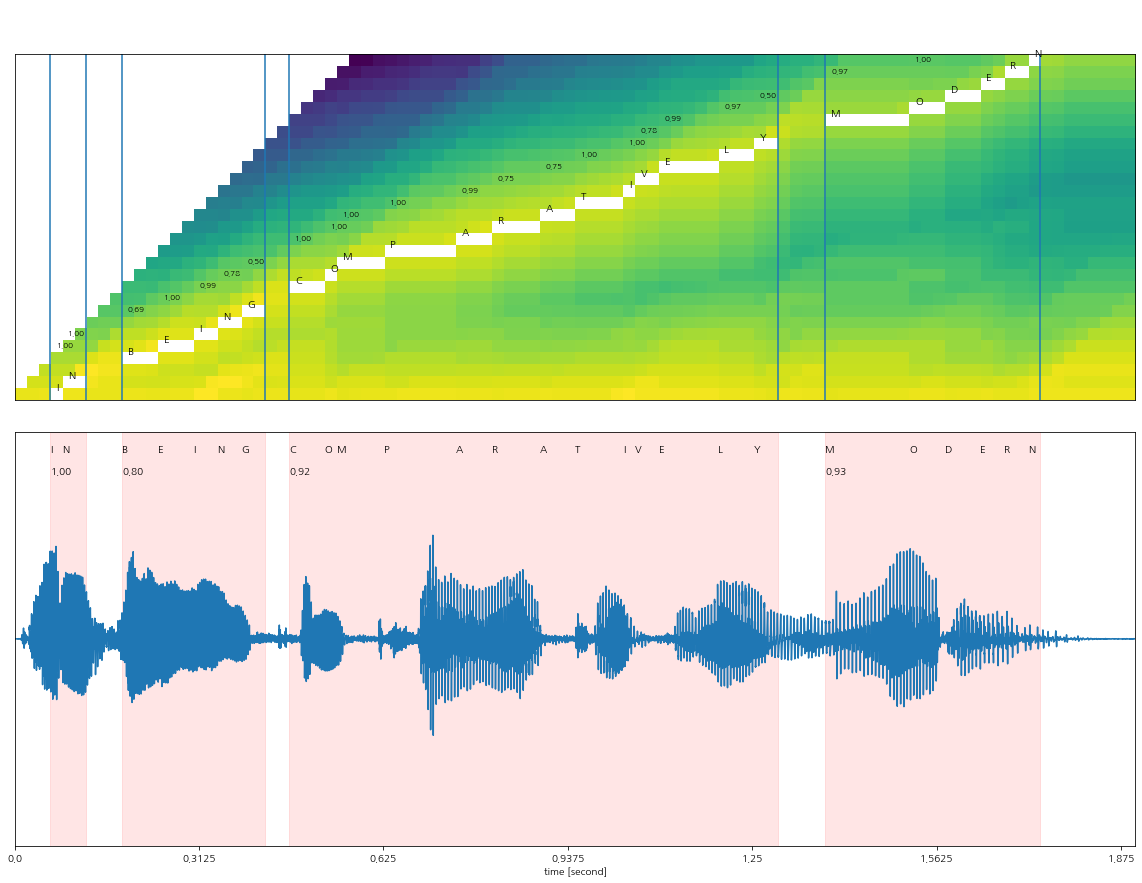

In [68]:
plot_alignments(trellis, segments, word_segments, waveform[0],)

# Korean(KSS ver4)

- This is a tutorial to make `Forced Aligned Textfile` using [Wav2vec 2.0](https://arxiv.org/abs/2006.11477) released from [fairseq](https://github.com/pytorch/fairseq/blob/main/examples/wav2vec/README.md).
- The original script to use wav2vec 2.0 as a forced aligner can be found in this [link](https://pytorch.org/tutorials/intermediate/forced_alignment_with_torchaudio_tutorial.html)
- To use Korean Wav2vec 2.0, you need to download trained model from this [link](https://drive.google.com/file/d/1BBYDTaBS0co7_VgaRowqk8NvFGA5bBgF/view?usp=sharing) which is trained by [JoungheeKim](https://github.com/JoungheeKim) using [Aihub Korean Dialog corpus](https://aihub.or.kr/aidata/105).
- After downloading the file, you must unzip it to use the model. 

In [25]:
import os
from dataclasses import dataclass
import torch
import torchaudio
import requests
import matplotlib
import matplotlib.pyplot as plt
import IPython
import pandas as pd
import tgt
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
from pathlib import Path
import unicodedata

In [26]:
## make sure you have korean font to visualize the output
import matplotlib.font_manager as fonm
font_list = [font.name for font in fonm.fontManager.ttflist]
plt.rcParams["font.family"] = 'NanumGothic'

In [27]:
## set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## load model
processor = Wav2Vec2Processor.from_pretrained("korean_wav2vec2")
model = Wav2Vec2ForCTC.from_pretrained("korean_wav2vec2")
model.to(device)

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureExtractor(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        )
        (2): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        )
        (3): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        )
        (4): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        )
        (5): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        )
        (6): Wav2Vec

In [28]:
## get dict
dictionary = processor.tokenizer.get_vocab()
labels = [item for item, idx in dictionary.items()]

## get sampling_rate
w2v_sample_rate = processor.feature_extractor.sampling_rate

In [29]:
## set meta and audio data path of KSS dataset
data_path = '/code/gitRepo/data/kss'
script_path = '/code/gitRepo/data/kss/transcript.v.1.4.txt'

In [30]:
with open(script_path, 'r') as f:
    scripts = f.readlines()

In [31]:
script_index = 1
scripts[script_index].strip().split('|')

['1/1_0001.wav',
 '그녀의 사랑을 얻기 위해 애썼지만 헛수고였다.',
 '그녀의 사랑을 얻기 위해 애썼지만 헛수고였다.',
 '그녀의 사랑을 얻기 위해 애썼지만 헛수고였다.',
 '4.0',
 'I tried in vain to win her love.']

In [32]:
item = scripts[script_index].strip().split('|')
audio_path = os.path.join(data_path, item[0])
if Path(audio_path).suffix == '':
    audio_path = '{}.wav'.format(audio_path)
transcript = item[2]

## normalize text for korean jamo
transcript = unicodedata.normalize('NFKD', transcript.lower())
print('[audio_path]', audio_path)
print('[transcript]', transcript)

[audio_path] /code/gitRepo/data/kss/1/1_0001.wav
[transcript] 그녀의 사랑을 얻기 위해 애썼지만 헛수고였다.


In [33]:
## get probs from wav2vec2
with torch.inference_mode():
    waveform, sample_rate = torchaudio.load(audio_path)

    ## only use mono
    if waveform.size(0) > 1:
        waveform = waveform[0, :].view(1, -1)

    if sample_rate != w2v_sample_rate:
        waveform = torchaudio.transforms.Resample(sample_rate, w2v_sample_rate)(waveform)
        sample_rate = w2v_sample_rate

    emissions = model(waveform.to(device))
    emissions = torch.log_softmax(emissions.logits, dim=-1)

emission = emissions[0].cpu().detach()

In [34]:
@dataclass
class Segment:
    label: str
    start: int
    end: int
    score: float

    def __repr__(self):
        return f"{self.label}\t({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

    @property
    def length(self):
        return self.end - self.start
    
@dataclass
class Point:
    token_index: int
    time_index: int
    score: float


def get_trellis(emission, tokens, blank_id=0):
    num_frame = emission.size(0)
    num_tokens = len(tokens)

    # Trellis has extra diemsions for both time axis and tokens.
    # The extra dim for tokens represents <SoS> (start-of-sentence)
    # The extra dim for time axis is for simplification of the code.
    trellis = torch.full((num_frame+1, num_tokens+1), -float('inf'))
    trellis[:, 0] = 0
    for t in range(num_frame):
        trellis[t+1, 1:] = torch.maximum(
            # Score for staying at the same token
            trellis[t, 1:] + emission[t, blank_id],
            # Score for changing to the next token
            trellis[t, :-1] + emission[t, tokens],
        )
    return trellis

def backtrack(trellis, emission, tokens, blank_id=0):
    # Note:
    # j and t are indices for trellis, which has extra dimensions
    # for time and tokens at the beginning.
    # When refering to time frame index `T` in trellis,
    # the corresponding index in emission is `T-1`.
    # Similarly, when refering to token index `J` in trellis,
    # the corresponding index in transcript is `J-1`.
    j = trellis.size(1) - 1
    t_start = torch.argmax(trellis[:, j]).item()

    path = []
    for t in range(t_start, 0, -1):
        # 1. Figure out if the current position was stay or change
        # Note (again):
        # `emission[J-1]` is the emission at time frame `J` of trellis dimension.
        # Score for token staying the same from time frame J-1 to T.
        stayed = trellis[t-1, j] + emission[t-1, blank_id]
        # Score for token changing from C-1 at T-1 to J at T.
        changed = trellis[t-1, j-1] + emission[t-1, tokens[j-1]]

        # 2. Store the path with frame-wise probability.
        prob = emission[t-1, tokens[j-1] if changed > stayed else 0].exp().item()
        # Return token index and time index in non-trellis coordinate.
        path.append(Point(j-1, t-1, prob))

        # 3. Update the token
        if changed > stayed:
            j -= 1
            if j == 0:
                break
    else:
        raise ValueError('Failed to align')
    return path[::-1]

def merge_repeats(path, transcript):
    
    i1, i2 = 0, 0
    segments = []
    while i1 < len(path):
        while i2 < len(path) and path[i1].token_index == path[i2].token_index:
            i2 += 1
        score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
        segments.append(Segment(transcript[path[i1].token_index], path[i1].time_index, path[i2-1].time_index + 1, score))
        i1 = i2
    return segments


def plot_alignments(trellis, segments, word_segments, waveform):
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != '|':
            trellis_with_path[seg.start+1:seg.end+1, i+1] = float('nan')

    fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 12.5))

    ax1.imshow(trellis_with_path[1:, 1:].T, origin='lower')
    ax1.set_xticks([])
    ax1.set_yticks([])

    for word in word_segments:
        ax1.axvline(word.start - 0.5)
        ax1.axvline(word.end - 0.5)

    for i, seg in enumerate(segments):
        if seg.label != '|':
            ax1.annotate(seg.label, (seg.start, i + 0.3))
            ax1.annotate(f'{seg.score:.2f}', (seg.start , i + 4), fontsize=8)

  # The original waveform
    ratio = waveform.size(0) / (trellis.size(0) - 1)
    ax2.plot(waveform)
    for word in word_segments:
        x0 = ratio * word.start
        x1 = ratio * word.end
        ax2.axvspan(x0, x1, alpha=0.1, color='red')
        ax2.annotate(f'{word.score:.2f}', (x0, 0.8))

    for seg in segments:
        if seg.label != '|':
            ax2.annotate(seg.label, (seg.start * ratio, 0.9))
    xticks = ax2.get_xticks()
    plt.xticks(xticks, xticks / w2v_sample_rate)
    ax2.set_xlabel('time [second]')
    ax2.set_yticks([])
    ax2.set_ylim(-1.0, 1.0)
    ax2.set_xlim(0, waveform.size(-1))
    plt.tight_layout()
    plt.show()
    
# Merge words
def merge_words(segments, separator='|'):
    words = []
    i1, i2 = 0, 0
    while i1 < len(segments):
        if i2 >= len(segments) or segments[i2].label == separator:
            if i1 != i2:
                segs = segments[i1:i2]
                word = ''.join([seg.label for seg in segs])
                score = sum(seg.score * seg.length for seg in segs) / sum(seg.length for seg in segs)
                words.append(Segment(word, segments[i1].start, segments[i2-1].end, score))
            i1 = i2 + 1
            i2 = i1
        else:
            i2 += 1
    return words

In [50]:
## make tokens
tokens = list()
converted_items = list()
new_transcript = '|' + transcript.replace(' ', '|').upper() + '|'
#new_transcript = transcript.replace(' ', '|').upper()
for c in new_transcript:
    if c not in dictionary:
        converted_items.append([len(tokens)-1, c])
    else:
        tokens.append(dictionary[c])

In [52]:
trellis = get_trellis(emission, tokens)
back_path = backtrack(trellis, emission, tokens)
segments = merge_repeats(back_path, [labels[token] for token in tokens])
segments = segments
word_segments = merge_words(segments)

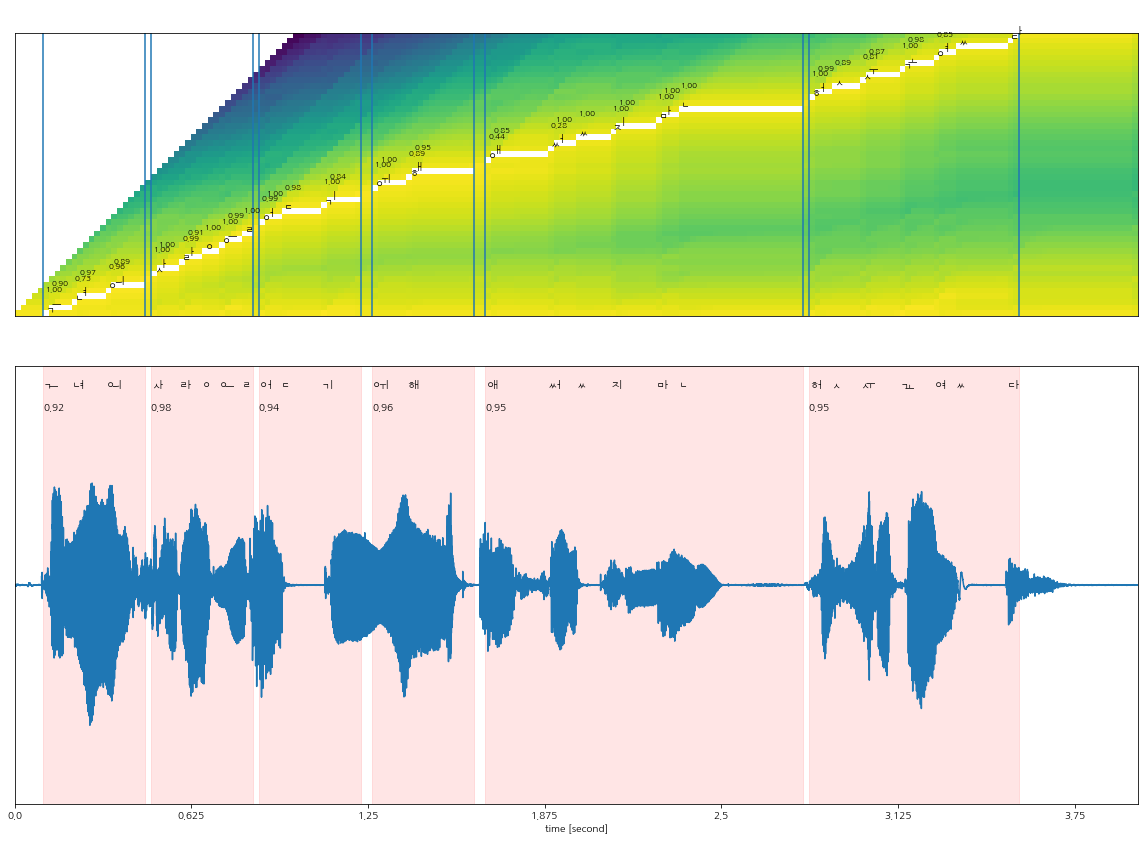

In [53]:
plot_alignments(trellis, segments, word_segments, waveform[0],)